In [1]:
import numpy as np
import pandas as pd
from scipy.ndimage import rotate
from skimage.util import montage
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
from keras.callbacks import CSVLogger
from tensorflow.keras import optimizers
import os
import nibabel as nib
import cv2 
from tensorflow.keras import backend as K
import glob
import skimage.io as io
import skimage.color as color
import random as r
import math
from nilearn import plotting
import warnings
from sklearn.preprocessing import MinMaxScaler


In [2]:
data  = np.load('/kaggle/input/aug3dn/input_data/train/train/image_1.npy')
print(data.shape)
data  = np.load('/kaggle/input/aug3dn/input_data/train/mask/image_1.npy')
print(data.shape)

(128, 128, 128, 3)
(128, 128, 128, 4)


In [3]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)         
            images.append(image)
    images = np.array(images)
    
    return(images)



def data_generator(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
               
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])
 
            
            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

############################################

In [4]:
train_img_dir = "/kaggle/input/aug3dn/input_data/train/train/"
train_mask_dir = "/kaggle/input/aug3dn/input_data/train/mask/"

val_img_dir = "/kaggle/input/aug3dn/input_data/val/train/"
val_mask_dir = "/kaggle/input/aug3dn/input_data/val/mask/"

train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

number_img = len(os.listdir(train_img_dir))
               

In [5]:
batch_size = 2
train_img_gen = data_generator(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_gen = data_generator(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

In [6]:
# Check shape of a single batch from generators
batch_train = next(iter(train_img_gen))
print("Train batch shape:", batch_train[0].shape)

batch_val = next(iter(val_img_gen))
print("Validation batch shape:", batch_val[0].shape)


Train batch shape: (2, 128, 128, 128, 3)
Validation batch shape: (2, 128, 128, 128, 3)


In [24]:
import tensorflow as tf
from tensorflow.keras import saving


@saving.register_keras_serializable()
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Calculate the Dice coefficient for binary segmentation.

    Parameters:
    y_true (tensor): Ground truth mask, shape (batch_size, depth, height, width, 1)
    y_pred (tensor): Predicted mask, shape (batch_size, depth, height, width, 1)
    smooth (float): Smoothing constant to prevent division by zero.

    Returns:
    tensor: Dice coefficient value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    
    dice_score = (2.0 * intersection + smooth) / (union + smooth)
    return dice_score

@saving.register_keras_serializable()
def iou(y_true, y_pred, smooth=1e-6):
    """
    Calculate Intersection over Union (IoU) for binary segmentation.

    Parameters:
    y_true (tensor): Ground truth mask, shape (batch_size, depth, height, width, 1)
    y_pred (tensor): Predicted mask, shape (batch_size, depth, height, width, 1)
    smooth (float): Smoothing constant to prevent division by zero.

    Returns:
    tensor: IoU value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score

@saving.register_keras_serializable()
def precision(y_true, y_pred, smooth=1e-6):
    """
    Calculate precision for binary segmentation.

    Parameters:
    y_true (tensor): Ground truth mask, shape (batch_size, depth, height, width, 1)
    y_pred (tensor): Predicted mask, shape (batch_size, depth, height, width, 1)
    smooth (float): Smoothing constant to prevent division by zero.

    Returns:
    tensor: Precision value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    true_positive = tf.reduce_sum(y_true * y_pred)
    predicted_positive = tf.reduce_sum(y_pred)

    precision_score = (true_positive + smooth) / (predicted_positive + smooth)
    return precision_score



In [10]:
# !pip install segmentation-models-3D
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)



In [11]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

def dense_block(x, num_filters):
    """Creates a dense block with DenseNet layers."""
    conv = layers.Conv3D(num_filters, kernel_size=(3, 3, 3), padding='same')(x)
    conv = layers.BatchNormalization()(conv)
    conv = layers.ReLU()(conv)
    return layers.concatenate([x, conv])

def transition_layer(x, num_filters):
    """Creates a transition layer with convolution and pooling."""
    x = layers.Conv3D(num_filters, kernel_size=(1, 1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

def attention_gate(x, g, inter_channels):
    """3D Attention Gate for U-Net skip connections."""
    theta_x = layers.Conv3D(inter_channels, kernel_size=(1, 1, 1), padding='same')(x)
    phi_g = layers.Conv3D(inter_channels, kernel_size=(1, 1, 1), padding='same')(g)
    add_xg = layers.Add()([theta_x, phi_g])
    act_xg = layers.Activation('relu')(add_xg)
    psi = layers.Conv3D(1, kernel_size=(1, 1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    attn_x = layers.Multiply()([x, sigmoid_xg])
    return attn_x

def create_densenet_3d_unet(input_shape, num_classes):
    """Create a 3D U-Net model with DenseNet blocks and attention gates."""
    inputs = layers.Input(shape=input_shape)

    # Encoder
    d1 = dense_block(inputs, 32)
    t1 = transition_layer(d1, 32)

    d2 = dense_block(t1, 64)
    t2 = transition_layer(d2, 64)

    d3 = dense_block(t2, 128)
    t3 = transition_layer(d3, 128)

    d4 = dense_block(t3, 256)
    t4 = transition_layer(d4, 256)

    # Bottleneck
    bottleneck = dense_block(t4, 512)

    # Decoder with attention gates
    u4 = layers.Conv3DTranspose(256, kernel_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(bottleneck)
    d4_attn = attention_gate(d4, u4, 128)
    u4 = layers.concatenate([u4, d4_attn])
    c5 = dense_block(u4, 256)

    u3 = layers.Conv3DTranspose(128, kernel_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    d3_attn = attention_gate(d3, u3, 64)
    u3 = layers.concatenate([u3, d3_attn])
    c6 = dense_block(u3, 128)

    u2 = layers.Conv3DTranspose(64, kernel_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    d2_attn = attention_gate(d2, u2, 32)
    u2 = layers.concatenate([u2, d2_attn])
    c7 = dense_block(u2, 64)

    u1 = layers.Conv3DTranspose(32, kernel_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    d1_attn = attention_gate(d1, u1, 16)
    u1 = layers.concatenate([u1, d1_attn])
    c8 = dense_block(u1, 32)

    outputs = layers.Conv3D(num_classes, kernel_size=(1, 1, 1), activation='softmax')(c8)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Example usage
input_shape = (128, 128, 128, 3)  # Adjust as needed
num_classes = 4  # Adjust to the number of classes in your dataset
model = create_densenet_3d_unet(input_shape, num_classes)



model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', dice_coefficient, iou, precision])
   

In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │      2,624 │ input_layer[0][0] │
│                     │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ input_layer[0][0… │
│ (Concatenate)       │ 128, 35)          │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │      1,152 │ concatenate[0][0] │
│                     │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 64,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling3D)      │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 64,    │     55,360 │ max_pooling3d[0]… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64,    │          0 │ max_pooling3d[0]… │
│ (Concatenate)       │ 64, 96)           │            │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 64,    │      6,208 │ concatenate_1[0]… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 32, 32,    │          0 │ re_lu_3[0][0]   

 Total params: 13,593,908 (51.86 MB)

 Trainable params: 13,590,004 (51.84 MB)

 Non-trainable params: 3,904 (15.25 KB)

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback to save the model with the best val_accuracy
checkpoint_callback = ModelCheckpoint(
    filepath='/kaggle/working/Den3dunetAttentionFull.keras',  
    monitor='val_dice_coefficient',    
    save_best_only=True,       
    mode='max',                
    verbose=1                 
)

In [15]:
history1=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch,
          callbacks=[checkpoint_callback]
          )



Epoch 1/50


I0000 00:00:1731062334.171630     102 service.cc:145] XLA service 0x7b7a2c007560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731062334.171696     102 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-11-08 10:39:17.643188: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng20{k2=6,k3=0} for conv (f32[32,3,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[2,3,128,128,128]{4,3,2,1,0}, f32[2,32,128,128,128]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-08 10:39:17.690822: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.047765081s
T

166/167 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9255 - dice_coefficient: 0.8809 - iou: 0.8219 - loss: 0.2357 - precision: 0.8809

2024-11-08 10:43:58.388069: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng20{k2=6,k3=0} for conv (f32[32,3,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[1,3,128,128,128]{4,3,2,1,0}, f32[1,32,128,128,128]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-08 10:43:58.419192: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.031312275s
Trying algorithm eng20{k2=6,k3=0} for conv (f32[32,3,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[1,3,128,128,128]{4,3,2,1,0}, f32[1,32,128,128,128]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"op

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9257 - dice_coefficient: 0.8812 - iou: 0.8223 - loss: 0.2351 - precision: 0.8812
Epoch 1: val_dice_coefficient improved from -inf to 0.93775, saving model to /kaggle/working/Den3dunetAttentionFull.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 413s 2s/step - accuracy: 0.9259 - dice_coefficient: 0.8815 - iou: 0.8227 - loss: 0.2345 - precision: 0.8815 - val_accuracy: 0.9584 - val_dice_coefficient: 0.9378 - val_iou: 0.8833 - val_loss: 0.1584 - val_precision: 0.9378
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9746 - dice_coefficient: 0.9624 - iou: 0.9277 - loss: 0.0792 - precision: 0.9624
Epoch 2: val_dice_coefficient improved from 0.93775 to 0.95868, saving model to /kaggle/working/Den3dunetAttentionFull.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.9746 - dice_coefficient: 0.9624 - iou: 0.9277 - loss: 0.0792 - precision: 0.9624 - val_accuracy: 0.9693 - val_dice_coefficient: 0.9587 - val_iou: 0.9210 - val_loss:

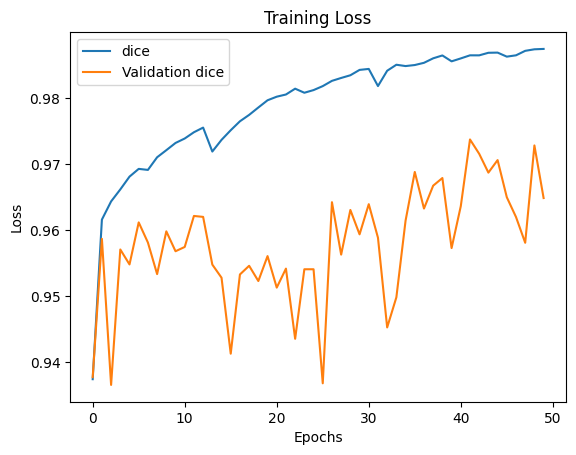

In [16]:
# Plot training history
plt.plot(history1.history['dice_coefficient'], label='dice')
plt.plot(history1.history['val_dice_coefficient'], label='Validation dice')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


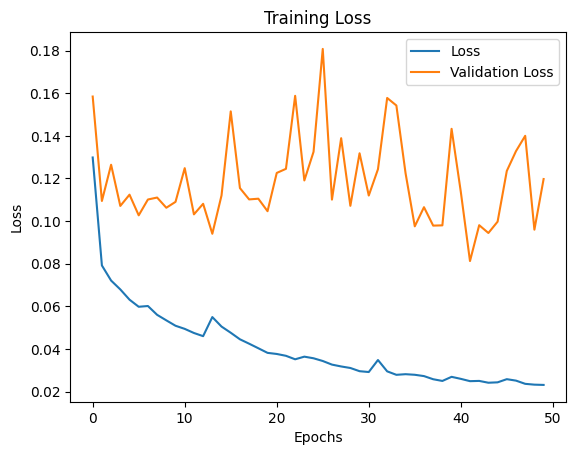

In [17]:
# Plot training history
plt.plot(history1.history['loss'], label='Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


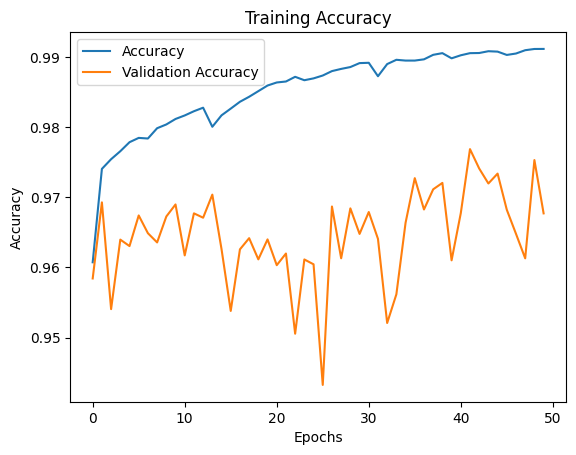

In [18]:
plt.plot(history1.history['accuracy'], label='Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
from keras.models import load_model
my_model = load_model('/kaggle/working/Den3dunetAttentionFull.keras', 
                      compile=False)

In [21]:
img_num = 14

test_img = np.load("/kaggle/input/aug3dn/input_data/val/train/image_100.npy")
test_mask = np.load("/kaggle/input/aug3dn/input_data/val/mask/image_100.npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


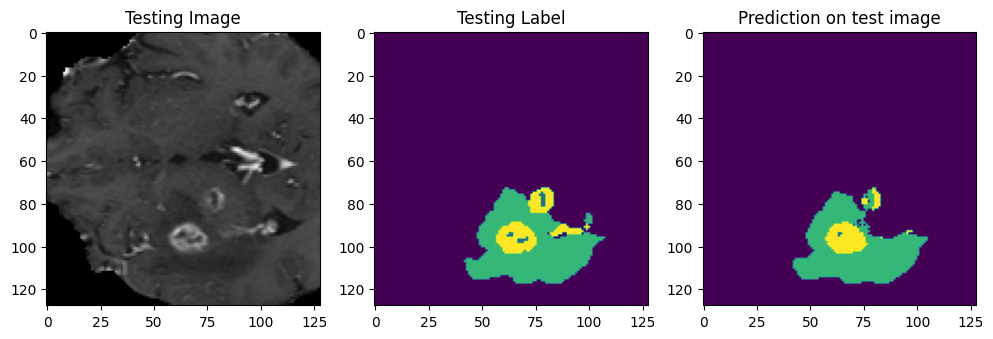

In [22]:
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

In [26]:
model = load_model('/kaggle/working/Den3dunetAttentionFull.keras', custom_objects={
    'dice_coef': dice_coefficient,
    'precision': precision,
    'iou': iou
})

# Step 3: Evaluate the model
# Assuming `test_gen` is a data generator for your test set
results = model.evaluate(val_img_gen, steps=val_steps_per_epoch)  # `test_steps` is len(test_data) // batch_size

# Print out metrics
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 602ms/step - accuracy: 0.9787 - dice_coefficient: 0.9756 - iou: 0.9536 - loss: 0.0719 - precision: 0.9756
loss: 0.0813
compile_metrics: 0.9769
